In [1]:
from datascience import *
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## Classification

In [2]:
banknotes = Table.read_table('banknote.csv')
banknotes

WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class
3.6216,8.6661,-2.8073,-0.44699,0
4.5459,8.1674,-2.4586,-1.4621,0
3.866,-2.6383,1.9242,0.10645,0
3.4566,9.5228,-4.0112,-3.5944,0
0.32924,-4.4552,4.5718,-0.9888,0
4.3684,9.6718,-3.9606,-3.1625,0
3.5912,3.0129,0.72888,0.56421,0
2.0922,-6.81,8.4636,-0.60216,0
3.2032,5.7588,-0.75345,-0.61251,0
1.5356,9.1772,-2.2718,-0.73535,0


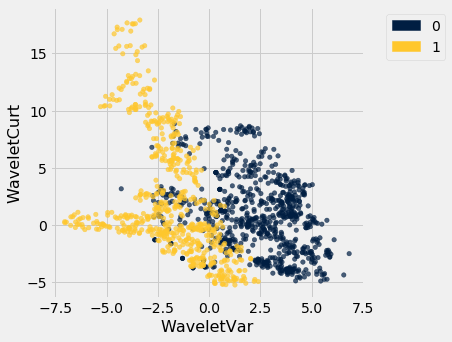

In [3]:
banknotes.scatter('WaveletVar', 'WaveletCurt', colors='Class')

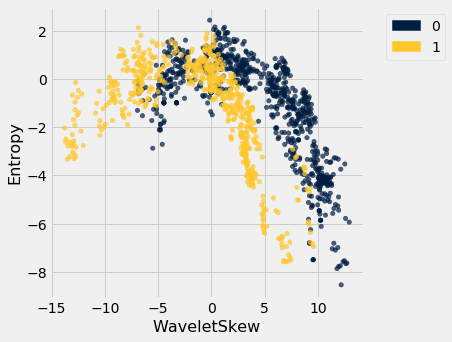

In [4]:
banknotes.scatter('WaveletSkew', 'Entropy', colors='Class')

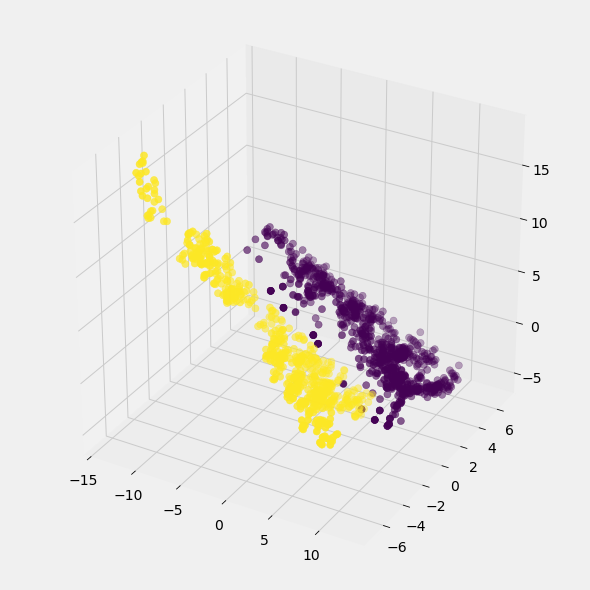

In [5]:
fig = plots.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.scatter(banknotes.column('WaveletSkew'), 
           banknotes.column('WaveletVar'), 
           banknotes.column('WaveletCurt'), 
           c=banknotes.column('Class'),
           cmap='viridis',
          s=50);

In [6]:
patients = Table.read_table('breast-cancer.csv').drop('ID')
patients.show(5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,1,1,1,2,1,3,1,1,0
5,4,4,5,7,10,3,2,1,0
3,1,1,1,2,2,3,1,1,0
6,8,8,1,3,4,3,7,1,0
4,1,1,3,2,1,3,1,1,0


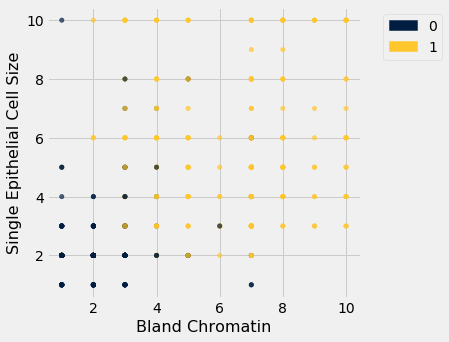

In [7]:
patients.scatter('Bland Chromatin', 'Single Epithelial Cell Size', colors='Class')

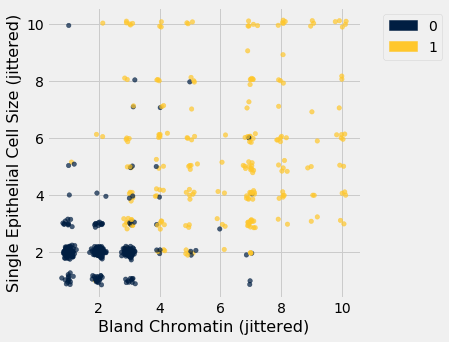

In [8]:
def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))

jittered = Table().with_columns([
        'Bland Chromatin (jittered)', 
        randomize_column(patients.column('Bland Chromatin')),
        'Single Epithelial Cell Size (jittered)', 
        randomize_column(patients.column('Single Epithelial Cell Size')),
        'Class',
        patients.column('Class')
    ])

jittered.scatter(0, 1, colors='Class')

## Distance ##

In [9]:
def distance(pt1, pt2):
    """Return the distance between two points, represented as arrays"""
    return np.sqrt(sum((pt1 - pt2)**2))

def row_distance(row1, row2):
    """Return the distance between two numerical rows of a table"""
    return distance(np.array(row1), np.array(row2))

In [10]:
attributes = patients.drop('Class')
attributes.show(3)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
5,1,1,1,2,1,3,1,1
5,4,4,5,7,10,3,2,1
3,1,1,1,2,2,3,1,1


In [11]:
row_distance(attributes.row(0), attributes.row(1))

11.874342087037917

In [12]:
row_distance(attributes.row(0), attributes.row(2))

2.23606797749979

In [13]:
row_distance(attributes.row(0), attributes.row(0))

0.0

## Classification Procedure ##

In [14]:
def distances(training, example):
    """Compute distance between example and every row in training.
    Return training augmented with Distance column"""
    distances = make_array()
    attributes = training.drop('Class')
    for row in attributes.rows:
        distances = np.append(distances, row_distance(row, example))
    return training.with_column('Distance', distances)

In [15]:
patients.take(15)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
7,4,6,4,6,1,4,3,1,1


In [16]:
example = attributes.row(15)
example

Row(Clump Thickness=7, Uniformity of Cell Size=4, Uniformity of Cell Shape=6, Marginal Adhesion=4, Single Epithelial Cell Size=6, Bare Nuclei=1, Bland Chromatin=4, Normal Nucleoli=3, Mitoses=1)

In [17]:
distances(patients.exclude(15), example).sort('Distance')

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Distance
8,4,6,3,3,1,4,3,1,0,3.31662
5,3,4,1,4,1,3,1,1,0,5.19615
5,4,5,1,8,1,3,6,1,0,5.2915
8,2,4,1,5,1,5,4,4,1,5.47723
9,5,5,4,4,5,4,3,3,1,5.47723
6,3,3,3,3,2,6,1,1,0,5.47723
9,5,5,2,2,2,5,1,1,1,5.65685
3,4,5,3,7,3,4,6,1,0,5.65685
5,3,3,2,3,1,3,1,1,0,5.65685
5,6,5,6,10,1,3,1,1,1,5.83095


In [18]:
def closest(training, example, k):
    """Return a table of the k closest neighbors to example"""
    return distances(training, example).sort('Distance').take(np.arange(k))

In [19]:
closest(patients.exclude(15), example, 5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Distance
8,4,6,3,3,1,4,3,1,0,3.31662
5,3,4,1,4,1,3,1,1,0,5.19615
5,4,5,1,8,1,3,6,1,0,5.2915
8,2,4,1,5,1,5,4,4,1,5.47723
9,5,5,4,4,5,4,3,3,1,5.47723


In [20]:
def majority_class(topk):
    """Return the class with the highest count"""
    return topk.group('Class').sort('count', descending=True).column(0).item(0)

def classify(training, example, k):
    "Return the majority class among the k nearest neighbors of example"
    return majority_class(closest(training, example, k))

In [21]:
classify(patients.exclude(15), example, 5)

0

In [22]:
patients.take(15)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
7,4,6,4,6,1,4,3,1,1


In [23]:
new_example = attributes.row(10)
classify(patients.exclude(10), new_example, 5)

0

In [24]:
patients.take(10)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
1,1,1,1,1,1,3,1,1,0


## Evaluation ##

In [25]:
patients.num_rows

683

In [26]:
shuffled = patients.sample(with_replacement=False) # Randomly permute the rows
training_set = shuffled.take(np.arange(342))
test_set  = shuffled.take(np.arange(342, 683))

In [27]:
def evaluate_accuracy(training, test, k):
    """Return the proportion of correctly classified examples 
    in the test set"""
    test_attributes = test.drop('Class')
    num_correct = 0
    for i in np.arange(test.num_rows):
        c = classify(training, test_attributes.row(i), k)
        num_correct = num_correct + (c == test.column('Class').item(i))
    return num_correct / test.num_rows

In [28]:
evaluate_accuracy(training_set, test_set, 5)

0.967741935483871

In [29]:
evaluate_accuracy(training_set, test_set, 3)

0.9618768328445748

In [30]:
evaluate_accuracy(training_set, test_set, 11)

0.9560117302052786

In [31]:
evaluate_accuracy(training_set, training_set, 1)

1.0